# Initialisation

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
import scipy.linalg as lin

from tqdm import tqdm
from scipy.special import gamma as Gamma

from plot_tools import *

#plt.rcParams["text.latex.preamble"].join([r"\usepackage{ket}"])

# Metropolis-Hasting

In [2]:
def target(x, distrib_param, type='alpha') :
    if type == 'alpha': 
        a = distrib_param[0]
        return np.exp(-0.5*(a-1/x)**2)/x**2
    if type == 'beta': 
        alpha,beta = distrib_param
        return x**(alpha-1)*(1-x)**(beta-1)
    
def alpha_target(x,a) : 
    if x > 0: return np.exp(-0.5*(a-1/x)**2)/x**2
    else: return 0

def beta_target(x, alpha, beta) : 
    if 0 <= x <= 1: return x**(alpha-1)*(1-x)**(beta-1)
    else: return 0

def exp_target(x) : 
    if x >= 0: return np.exp(-x)
    else: return 0

In [3]:
def plot_MH_sample(sample, Naccepted, Nsample, true_pdf) :

    create_plot('sample number',r'$x$',[0,len(sample)],title='Acceptance rate: '+str('{:.2f}'.format(Naccepted/Nsample)))

    plt.plot(np.arange(len(sample)),sample,marker='.')


    Nbin = 50
    x = np.linspace(0,10,10000)

    pdf = true_pdf(x)
    xmax = x[np.logical_and(pdf<1e-3,x>x[np.argmax(pdf)])][0]
    
    create_plot(r'$x$','distribution',[0,xmax])

    plt.hist(sample,bins=Nbin,density=True,histtype='step',label='MH sample')
    plt.plot(x,pdf,label='true PDF')

    plt.legend()
    plt.show()


def MH_sampler(start_value, Nsample, proposal_sigma, target, target_params, true_pdf, plot=True) :

    sample = np.zeros(Nsample)
    sample[0] = start_value

    Naccepted = 0

    for i in tqdm(range(1,Nsample)):
    
        candidate = ss.norm(sample[i-1],proposal_sigma).rvs() # draw a candidate from proposal distribution

        r = target(candidate,*target_params)/target(sample[i-1],*target_params)
        a = min(1,r)
        
        if np.random.uniform() < a: # accept candidate if alpha>=1 or accept candidate with proba alpha if 0<alpha<1

            sample[i] = candidate
            Naccepted += 1

        else: sample[i] = sample[i-1]

    sample = sample[Nsample//10:] # remove beginning of the Markov chain

    if plot: plot_MH_sample(sample,Naccepted,Nsample,true_pdf)
    
    return sample, Naccepted/Nsample

## Examples

  0%|          | 0/9999 [00:00<?, ?it/s]

100%|██████████| 9999/9999 [00:07<00:00, 1291.91it/s]


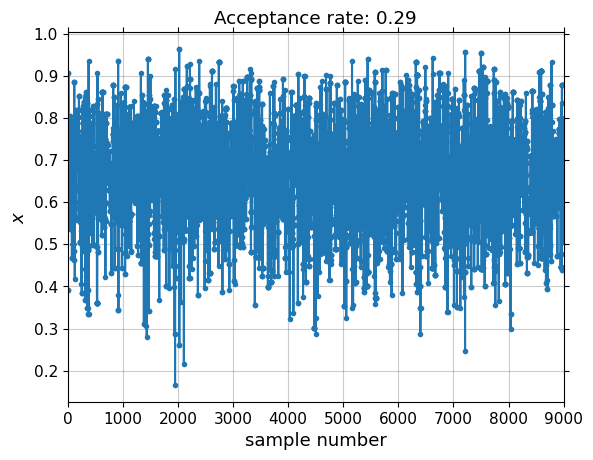

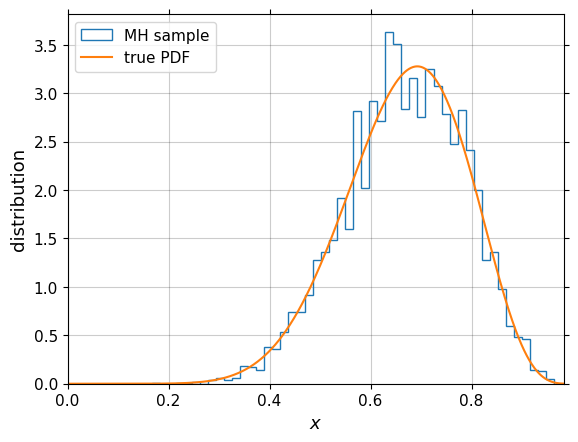

In [4]:
Nsample = 10000

sample, accepted_rate = MH_sampler(0.5,Nsample,0.5,beta_target,[10,5],ss.beta(10,5).pdf)

100%|██████████| 9999/9999 [00:08<00:00, 1157.60it/s]


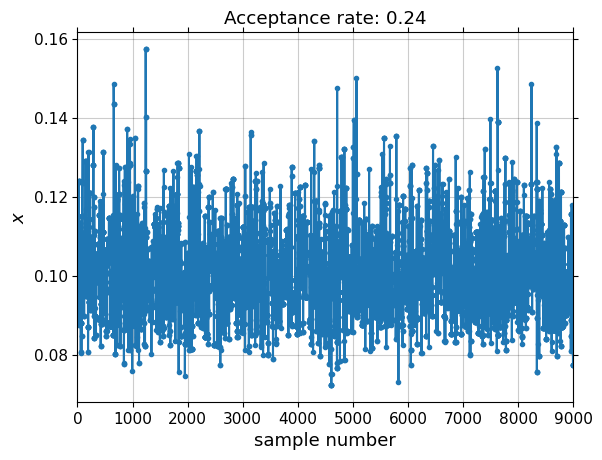

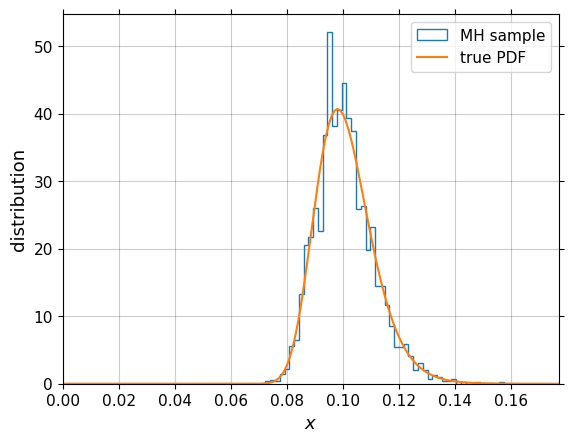

In [5]:
Nsample = 10000

sample, accepted_rate = MH_sampler(0.5,Nsample,0.05,alpha_target,[10],ss.alpha(10).pdf)

100%|██████████| 9999/9999 [00:08<00:00, 1176.92it/s]


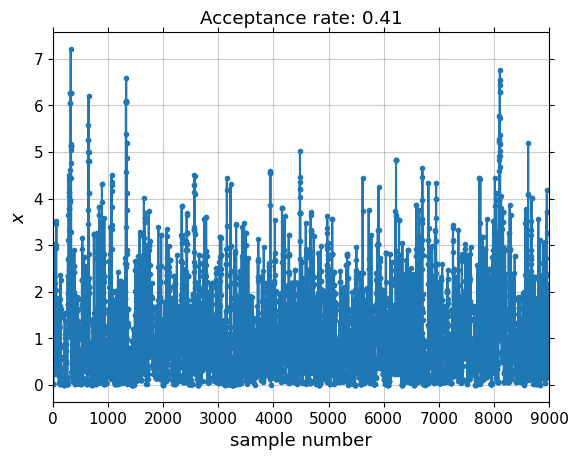

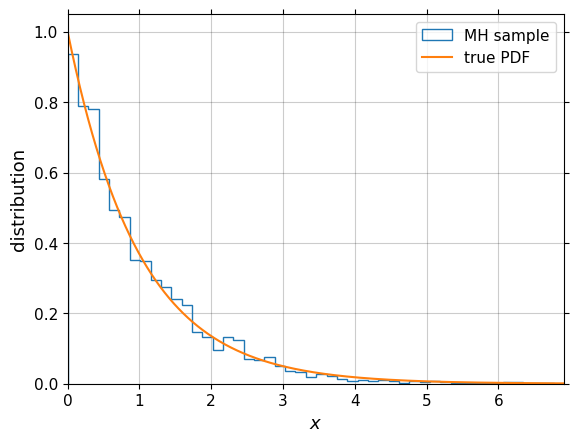

In [6]:
Nsample = 10000

sample, accepted_rate = MH_sampler(0.5,Nsample,1.5,exp_target,[],lambda x: np.exp(-x))

# Transverse Ising Model (Rubbish)

In [45]:
def plot_state(state, title='') :

    plt.figure()
    n = np.arange(0,len(state),1)

    for i in range(len(state)):

        if np.array_equal(state[i],[1,0]):
            plt.scatter(n[i],0,color='r')

        elif np.array_equal(state[i],[0,1]):
            plt.scatter(n[i],0,color='b')

    plt.scatter([],[],color='r',label=r'$\uparrow$')
    plt.scatter([],[],color='b',label=r'$\downarrow$')

    plt.title(title)
    plt.legend()
    plt.show()

def mul(a,b) : # matrice multiplication in our 2N-dim Hilbert-space

    ab = np.zeros((len(a),*np.shape(a[0]@b[0])))

    for i in range(len(a)) :
        ab[i] = a[i]@b[i]

    return ab

In [55]:
N = 10 # number of sites
J = 1
g = 1

sz = np.array([[1,0],[0,-1]])
sx = np.array([[0,1],[1,0]])
id = np.array([[1,0],[0,1]])

H1 = np.sum(-J*np.array([[sz if (j==i or j==i+1) else id for j in range(N)] if i!=N-1 else [sz if (j==0 or j==N-1) else [[1,0],[0,1]] for j in range(N)] for i in range(N)]),axis=0)
H2 = np.sum(-J*g*np.array([[sx if j==i else id for j in range(N)] for i in range(N)]),axis=0)

H = H1 + H2
C = np.array([sx for i in range(N)])

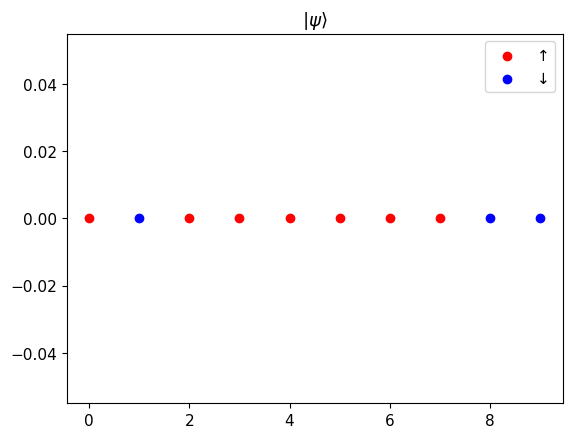

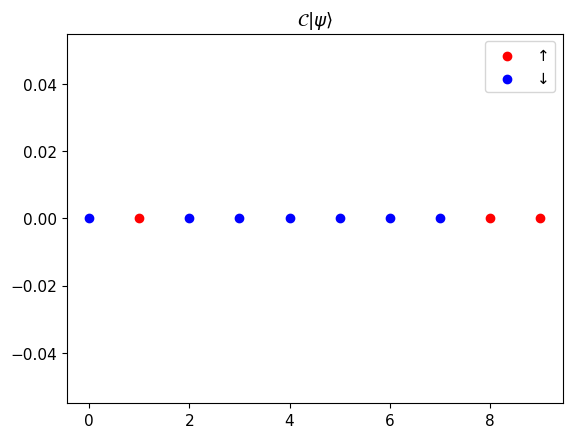

In [56]:
state1 = [[1,0]  if np.random.uniform()<0.5 else [0,1] for i in range(N)]

plot_state(state1,title=r'$|\psi\rangle$')
plot_state(mul(C,state1),title=r'$\mathcal{C}|\psi\rangle$')

In [79]:
H[0]@C[0] - C[0]@H[0]

array([[ 0, -4],
       [ 4,  0]])

In [78]:
mul(H,C)-mul(C,H)

array([[[ 0., -4.],
        [ 4.,  0.]],

       [[ 0., -4.],
        [ 4.,  0.]],

       [[ 0., -4.],
        [ 4.,  0.]],

       [[ 0., -4.],
        [ 4.,  0.]],

       [[ 0., -4.],
        [ 4.,  0.]],

       [[ 0., -4.],
        [ 4.,  0.]],

       [[ 0., -4.],
        [ 4.,  0.]],

       [[ 0., -4.],
        [ 4.,  0.]],

       [[ 0., -4.],
        [ 4.,  0.]],

       [[ 0., -4.],
        [ 4.,  0.]]])

## Disordered phase $g\gg 1$

In [77]:
ground_state = np.array([(np.array([1,0])+np.array([0,1]))/np.sqrt(2) for i in range(10)])



print(mul(H2,ground_state))
print(-N*J*g*ground_state)


[[-7.07106781 -7.07106781]
 [-7.07106781 -7.07106781]
 [-7.07106781 -7.07106781]
 [-7.07106781 -7.07106781]
 [-7.07106781 -7.07106781]
 [-7.07106781 -7.07106781]
 [-7.07106781 -7.07106781]
 [-7.07106781 -7.07106781]
 [-7.07106781 -7.07106781]
 [-7.07106781 -7.07106781]]
[[-7.07106781 -7.07106781]
 [-7.07106781 -7.07106781]
 [-7.07106781 -7.07106781]
 [-7.07106781 -7.07106781]
 [-7.07106781 -7.07106781]
 [-7.07106781 -7.07106781]
 [-7.07106781 -7.07106781]
 [-7.07106781 -7.07106781]
 [-7.07106781 -7.07106781]
 [-7.07106781 -7.07106781]]


In [80]:
np.array([[sz if (j==i or j==i+1) else id for j in range(N)] if i!=N-1 else [sz if (j==0 or j==N-1) else [[1,0],[0,1]] for j in range(N)] for i in range(N)])

array([[[[ 1,  0],
         [ 0, -1]],

        [[ 1,  0],
         [ 0, -1]],

        [[ 1,  0],
         [ 0,  1]],

        [[ 1,  0],
         [ 0,  1]],

        [[ 1,  0],
         [ 0,  1]],

        [[ 1,  0],
         [ 0,  1]],

        [[ 1,  0],
         [ 0,  1]],

        [[ 1,  0],
         [ 0,  1]],

        [[ 1,  0],
         [ 0,  1]],

        [[ 1,  0],
         [ 0,  1]]],


       [[[ 1,  0],
         [ 0,  1]],

        [[ 1,  0],
         [ 0, -1]],

        [[ 1,  0],
         [ 0, -1]],

        [[ 1,  0],
         [ 0,  1]],

        [[ 1,  0],
         [ 0,  1]],

        [[ 1,  0],
         [ 0,  1]],

        [[ 1,  0],
         [ 0,  1]],

        [[ 1,  0],
         [ 0,  1]],

        [[ 1,  0],
         [ 0,  1]],

        [[ 1,  0],
         [ 0,  1]]],


       [[[ 1,  0],
         [ 0,  1]],

        [[ 1,  0],
         [ 0,  1]],

        [[ 1,  0],
         [ 0, -1]],

        [[ 1,  0],
         [ 0, -1]],

        [[ 1,  0],
         [ 0,  1]

In [90]:
print(ground_state)

[[0.70710678 0.70710678]
 [0.70710678 0.70710678]
 [0.70710678 0.70710678]
 [0.70710678 0.70710678]
 [0.70710678 0.70710678]
 [0.70710678 0.70710678]
 [0.70710678 0.70710678]
 [0.70710678 0.70710678]
 [0.70710678 0.70710678]
 [0.70710678 0.70710678]]


In [88]:
print(mul(H1,ground_state))

-J*np.array([sz@ground_state[i]*sz@ground_state[i+1] if i!=9 else sz@ground_state[i]*sz@ground_state[0] for i in range(10)])

[[-7.07106781 -4.24264069]
 [-7.07106781 -4.24264069]
 [-7.07106781 -4.24264069]
 [-7.07106781 -4.24264069]
 [-7.07106781 -4.24264069]
 [-7.07106781 -4.24264069]
 [-7.07106781 -4.24264069]
 [-7.07106781 -4.24264069]
 [-7.07106781 -4.24264069]
 [-7.07106781 -4.24264069]]


array([[-0.5, -0.5],
       [-0.5, -0.5],
       [-0.5, -0.5],
       [-0.5, -0.5],
       [-0.5, -0.5],
       [-0.5, -0.5],
       [-0.5, -0.5],
       [-0.5, -0.5],
       [-0.5, -0.5],
       [-0.5, -0.5]])